**Student ID**: 20811152  
**Files**: `cwk_data_20811152.csv`  
**Notes**: `duration` is explored but **excluded** from predictive models (coursework rule).

## Requirements
`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`.


In [64]:
%pip install pandas numpy scikit-learn matplotlib seaborn joblib

Note: you may need to restart the kernel to use updated packages.


In [65]:
# Cell: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, precision_recall_curve
)


In [66]:
# plotting settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('whitegrid')

In [67]:
# Cell: Load dataset
DATA_PATH = '/Users/shreyu/VSCODE/junk/UoN-Business-Analytics/FBA/coursework/cwk_data_20811152.csv'
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Target distribution:")
print(df['y'].value_counts())

Shape: (4000, 16)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Target distribution:
y
no     3200
yes     800
Name: count, dtype: int64


In [68]:
df.head(8)

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,poutcome,y
0,40,management,married,tertiary,no,-17,yes,yes,cellular,11,474,1,256,1,success,yes
1,55,management,divorced,tertiary,no,2037,no,no,cellular,4,305,2,94,3,success,yes
2,34,student,single,unknown,no,1011,no,no,cellular,1,253,1,-1,0,unknown,yes
3,39,technician,married,secondary,no,4101,yes,no,cellular,18,146,2,264,1,other,yes
4,26,blue-collar,single,secondary,no,1006,yes,no,cellular,14,667,1,-1,0,unknown,yes
5,40,technician,divorced,secondary,no,311,no,no,cellular,6,738,2,-1,0,unknown,yes
6,35,management,single,tertiary,no,68,no,no,unknown,6,1085,1,-1,0,unknown,yes
7,33,student,married,secondary,no,1536,no,no,cellular,9,359,1,92,3,success,yes


In [69]:
display(df.describe(include='all').T)
print("\nMissing values per column:")
print(df.isnull().sum())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,4000.0,NaN,NaN,NaN,41.0355,10.7738,18.0,33.0,39.0,48.0,95.0
job,4000,12,blue-collar,836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,4000,3,married,2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,4000,4,secondary,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,4000,2,no,3933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,4000.0,NaN,NaN,NaN,1344.92125,2662.04662,-1884.0,75.0,459.0,1524.5,39098.0
housing,4000,2,yes,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,4000,2,no,3388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,4000,3,cellular,2659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,4000.0,NaN,NaN,NaN,15.93175,8.32742,1.0,8.0,16.0,21.0,31.0



Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


## Target class imbalance
Note the target distribution above. This dataset typically has many more 'no' than 'yes' (roughly 80:20).
We will use stratified sampling and metrics that reflect imbalance (precision, recall, F1, ROC AUC).

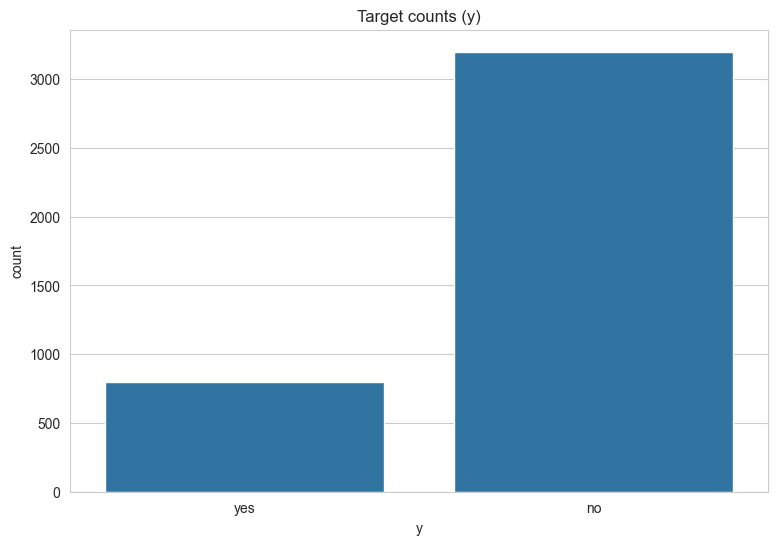

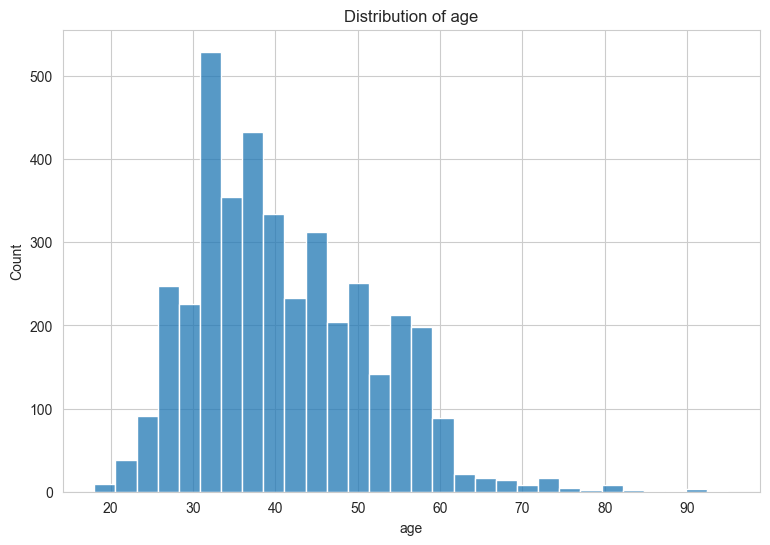

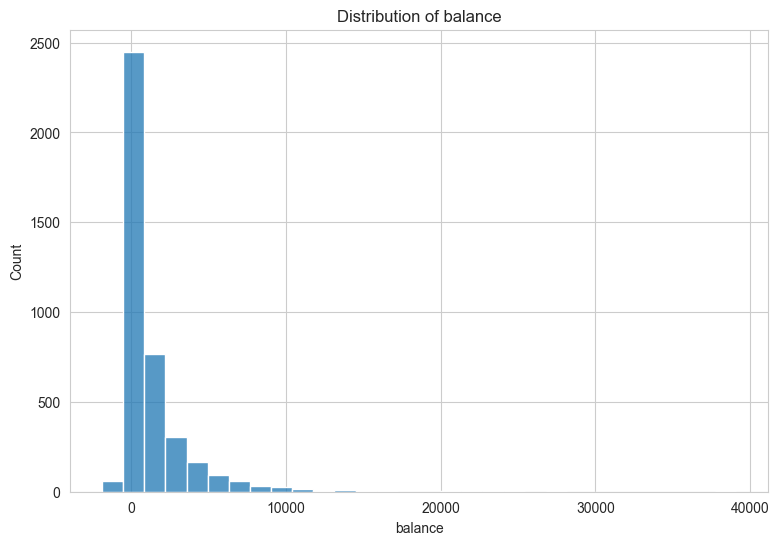

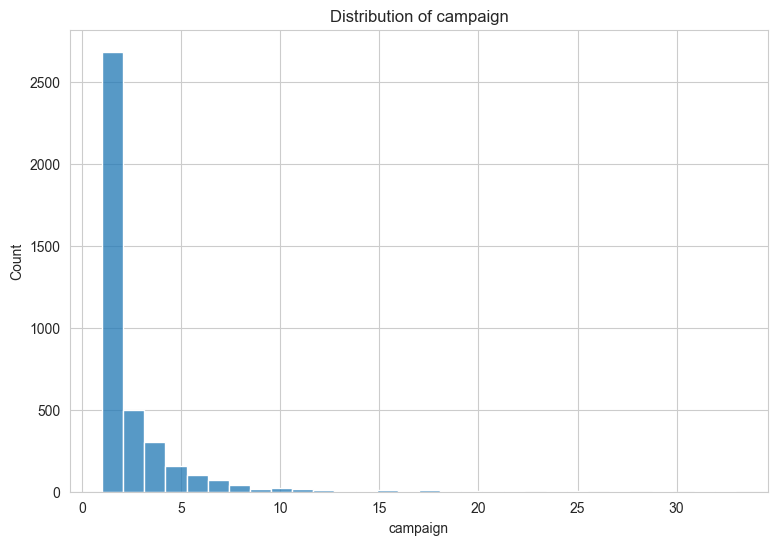

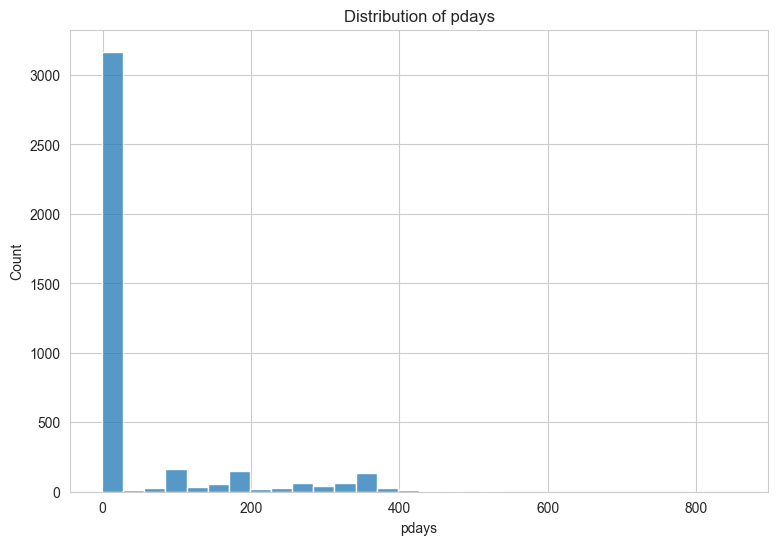

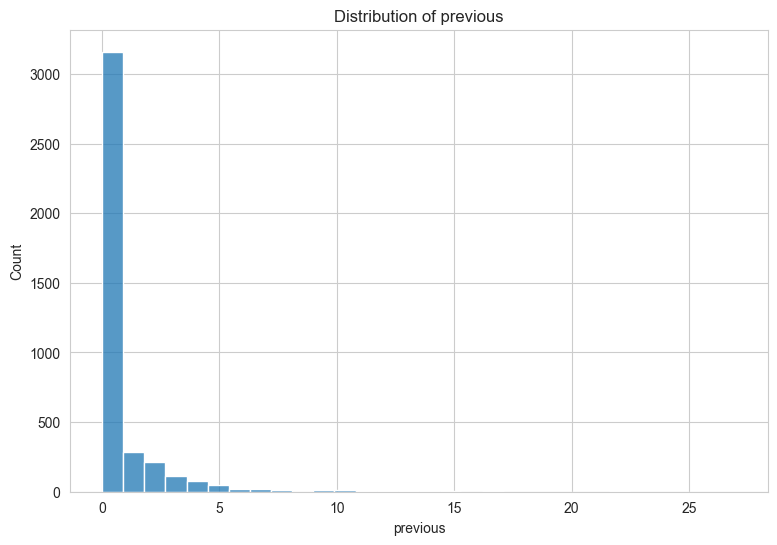

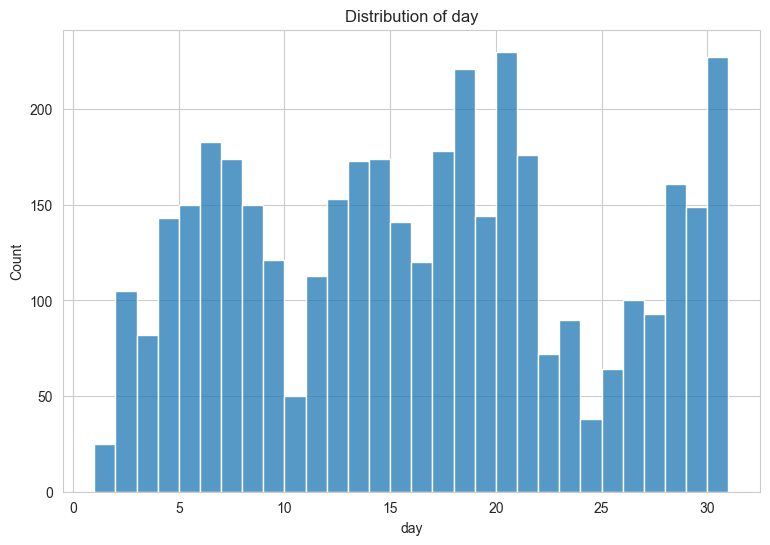

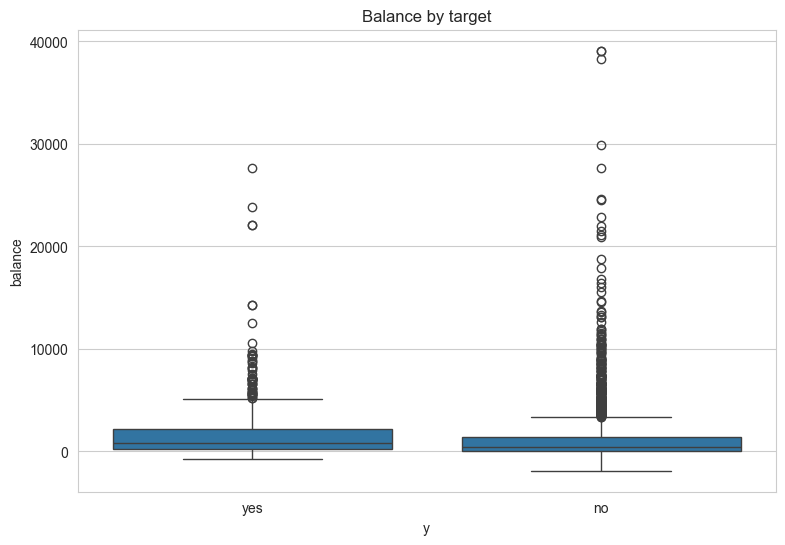

In [70]:
# Plots to include in report
# 1) Target count
sns.countplot(x='y', data=df)
plt.title('Target counts (y)')
plt.show()

# 2) Numeric distributions for a few key features
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']
for c in num_cols:
    plt.figure()
    sns.histplot(df[c], bins=30, kde=False)
    plt.title(f'Distribution of {c}')
    plt.show()

# 3) Balance vs target boxplot
plt.figure()
sns.boxplot(x='y', y='balance', data=df)
plt.title('Balance by target')
plt.show()

### On `duration`
`duration` is strongly correlated with `y` (longer calls => higher chance of sale). However the coursework forbids using it for predictions because it isn't known *before* placing the call's outcome. We'll exclude it from the prediction pipeline but *report* its relationship in Section A.

Below we compute basic stats of duration by target for the report.

In [71]:
# duration exploration
df.groupby('y')['duration'].agg(['count','median','mean','std']).T

y,no,yes
count,3200.000000,800.000000
median,167.500000,449.000000
mean,227.496250,555.740000
std,223.999717,411.559177


In [72]:
# Prepare X, y — exclude duration from predictors and drop y
X = df.drop(columns=['y', 'duration'])
y = df['y'].map({'yes':1, 'no':0}).astype(int)

# identify numeric and categorical automatically
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']


In [73]:
# Preprocessing pipelines for numeric and categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

In [74]:
# Models dictionary
models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [75]:
# Evaluate models with stratified 5-fold CV
from sklearn.model_selection import cross_val_predict

results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])
    print(f"\nRunning CV for {name} ...")
    # predictions
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method='predict')
    # probabilities if available
    try:
        y_proba = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:,1]
        roc = roc_auc_score(y, y_proba)
    except Exception:
        y_proba = None
        roc = None
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    cm = confusion_matrix(y, y_pred)
    print(name, "-> acc: %.4f, prec: %.4f, rec: %.4f, f1: %.4f, roc_auc: %s" % (acc, prec, rec, f1, f"{roc:.3f}" if roc else "N/A"))
    print("Confusion matrix:\n", cm)
    results[name] = dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc, cm=cm)


Running CV for LogisticRegression ...
LogisticRegression -> acc: 0.8327, prec: 0.8134, rec: 0.2125, f1: 0.3370, roc_auc: 0.746
Confusion matrix:
 [[3161   39]
 [ 630  170]]

Running CV for DecisionTree ...
DecisionTree -> acc: 0.8297, prec: 0.7262, rec: 0.2387, f1: 0.3594, roc_auc: 0.717
Confusion matrix:
 [[3128   72]
 [ 609  191]]

Running CV for RandomForest ...
RandomForest -> acc: 0.8570, prec: 0.7740, rec: 0.4025, f1: 0.5296, roc_auc: 0.808
Confusion matrix:
 [[3106   94]
 [ 478  322]]


In [76]:
# summary table
metrics_df = pd.DataFrame(results).T[['accuracy','precision','recall','f1','roc_auc']]
metrics_df = metrics_df.sort_values(by='f1', ascending=False)
display(metrics_df)
# save for your submission
# metrics_df.to_csv("model_metrics_summary.csv", index=True)
# print("Saved model_metrics_summary.csv")

,accuracy,precision,recall,f1,roc_auc
RandomForest,0.857,0.774038,0.4025,0.529605,0.80846
DecisionTree,0.82975,0.726236,0.23875,0.35936,0.71745
LogisticRegression,0.83275,0.813397,0.2125,0.336967,0.746484


In [77]:
# Choose final model by highest F1 (or choose manually)
best_model_name = metrics_df.index[0]
print("Selected final model by F1:", best_model_name)
best_clf = models[best_model_name]
final_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', best_clf)])
final_pipeline.fit(X, y)

# Save pipeline
out_path = Path("final_pipeline.pkl")
joblib.dump(final_pipeline, out_path)
print("Saved final pipeline to:", out_path)

Selected final model by F1: RandomForest
Saved final pipeline to: final_pipeline.pkl


In [78]:
# If final model supports feature_importances_, extract them
clf = final_pipeline.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    # get feature names after transformer
    # numeric names
    num_names = numeric_features
    # categorical OHE names
    ohe = final_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feat_names = num_names + cat_names
    importances = clf.feature_importances_
    imp_ser = pd.Series(importances[:len(feat_names)], index=feat_names).sort_values(ascending=False)
    display(imp_ser.head(20))
else:
    print("Classifier does not expose feature_importances_. Consider using permutation importance if needed.")

balance                0.167777
age                    0.144504
day                    0.133874
poutcome_success       0.065297
campaign               0.064389
pdays                  0.057007
previous               0.028654
housing_yes            0.020577
housing_no             0.018315
education_secondary    0.016866
marital_married        0.016693
education_tertiary     0.016055
job_technician         0.015621
contact_unknown        0.015537
job_admin.             0.015266
poutcome_unknown       0.014648
marital_single         0.014428
contact_cellular       0.014303
job_blue-collar        0.014292
job_management         0.014164
dtype: float64

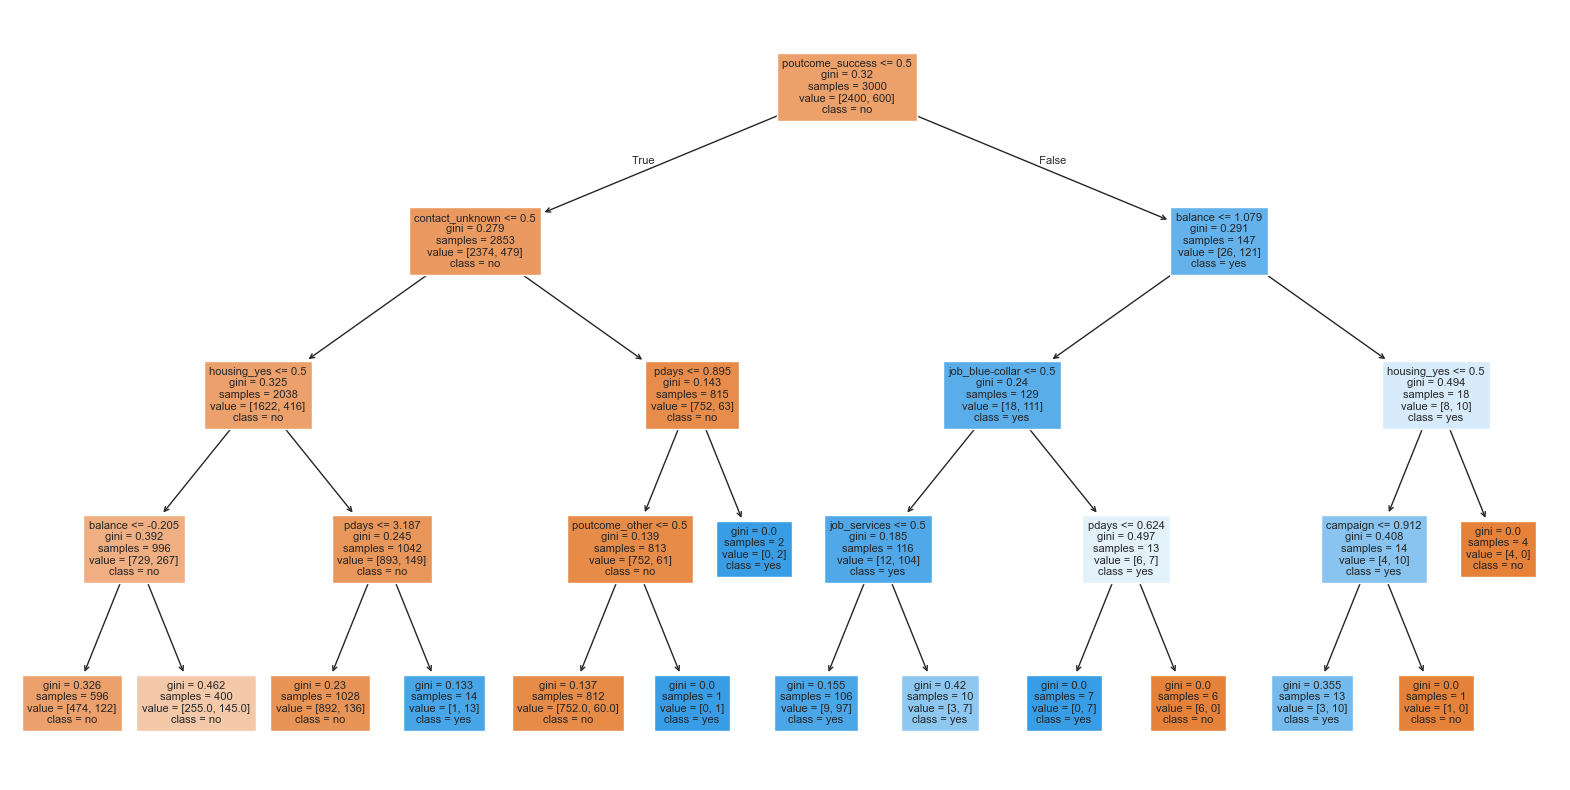

In [79]:
# Create a small decision tree for interpretability (train shallow tree on subset)
viz_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
viz_pipe.fit(X_train, y_train)

# get feature names for plotting
num_names = numeric_features
ohe = viz_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out(categorical_features))
feat_names = num_names + cat_names

plt.figure(figsize=(20,10))
plot_tree(viz_pipe.named_steps['clf'], feature_names=feat_names, class_names=['no','yes'], filled=True, fontsize=8)
plt.show()

,threshold,precision,recall
0,0.00,0.200000,1.00000
1,0.05,0.239761,0.95125
2,0.10,0.288462,0.88125
3,0.15,0.349477,0.79375
4,0.20,0.405046,0.72250
5,0.25,0.479224,0.64875
6,0.30,0.533937,0.59000
7,0.35,0.592958,0.52625
8,0.40,0.647555,0.48000
9,0.45,0.715139,0.44875


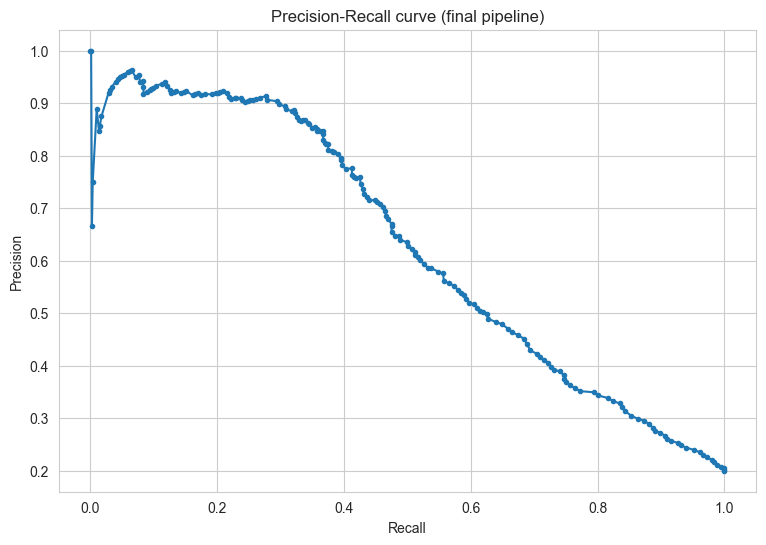

In [80]:
# Use the final pipeline to get cross-validated probabilities for precision-recall analysis
y_proba = cross_val_predict(final_pipeline, X, y, cv=cv, method='predict_proba')[:,1]

precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Build a small table of thresholds
thr_df = pd.DataFrame({
    'threshold': np.append(thresholds, 1.0),
    'precision': precisions,
    'recall': recalls
})
# show thresholds spaced roughly evenly for reporting
display(thr_df.iloc[::max(1, len(thr_df)//20), :].reset_index(drop=True))
# plot PR curve
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (final pipeline)')
plt.show()

In [81]:
# If you want calibrated probabilities, use CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(estimator=best_clf, cv=5, method='isotonic')
cal_pipeline = Pipeline([('pre', preprocessor), ('clf', calibrated)])
cal_pipeline.fit(X, y)

# Save calibrated pipeline if preferred
joblib.dump(cal_pipeline, "final_pipeline_calibrated.pkl")
print("Saved calibrated pipeline.")

Saved calibrated pipeline.


## Decision thresholding guidance
To pick a threshold, estimate:
- expected revenue when contacting a real buyer (R)
- expected cost per contact (C)

Then expected profit per contact = P(yes|features)*R - C.

Choose threshold T such that expected profit >= 0 => P(yes|features) >= C/R.

If you give me C and R, I'll compute the expected profit at different thresholds and recommend the best threshold.

In [82]:
# Example code to compute expected profit at several thresholds (customize C and R)
def expected_profit_at_threshold(y_proba, threshold, R=100, C=10):
    preds = (y_proba >= threshold).astype(int)
    # true positives, false positives
    tp = ((preds==1) & (y==1)).sum()
    fp = ((preds==1) & (y==0)).sum()
    # profit
    profit = tp * R - (tp + fp) * C
    return profit

# sample call: (uncomment and adjust R and C)
# print(expected_profit_at_threshold(y_proba, 0.4, R=150, C=10))

## Files to include in your ZIP submission
- `final_pipeline.pkl` (or `final_pipeline_calibrated.pkl`)
- `model_metrics_summary.csv`
- `notebook.ipynb` (this notebook)
- `README.txt` or `README.md` with instructions and package requirements
- optional: `decision_tree_viz.png` and EDA figures

In [83]:
readme = """
Files:
- final_pipeline.pkl : trained pipeline (preprocessing + classifier)
- model_metrics_summary.csv : numeric results from CV
How to use:
1) Ensure python packages: pandas, numpy, scikit-learn, joblib
2) Load pipeline: joblib.load('final_pipeline.pkl')
3) Provide new CSV with same columns except 'y' and 'duration'
4) Use pipe.predict_proba(new)[:,1] to get probability of 'yes'
"""
# Path("README.txt").write_text(readme)
print("README.txt saved.")

README.txt saved.


### Short methodology notes (for the report)
- CV: Stratified 5-fold cross-validation was used to evaluate models to preserve class balance across folds.
- Metrics: Report accuracy, precision, recall, F1 and ROC AUC. Focus on **precision/recall tradeoff** because company wants to avoid wasted calls (precision) while still finding buyers (recall).
- Leakage: `duration` is excluded from prediction due to it being a post-call variable.
- Final model: trained on full dataset and saved as `final_pipeline.pkl`.